In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

import torch
import random
import numpy as np


# Seed
seed = 311552007
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
import numpy as np

def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)


    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))
   

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    return train_data, train_label, test_data, test_label




In [4]:
from torch.utils.data import Dataset, DataLoader
class BCIDataset(Dataset):
    def __init__(self, data, label):
        self.x, self.y = data, label
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.shape[0]
        

## EEGNet

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class EEGNet(nn.Module):
    def __init__(self, act_func):
        super(EEGNet, self).__init__()
        if act_func == "leakyrelu":
            act = nn.LeakyReLU()
        elif act_func == "relu":
            act = nn.ReLU()
        elif act_func == "elu":
            act = nn.ELU()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            act,
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            act,
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(736, 2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.seperableConv(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.classify(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## DeepConvNet

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class DeepConvNet(nn.Module):
	def __init__(self, act_func):
		super(DeepConvNet, self).__init__()
		if act_func == "leakyrelu":
			act = nn.LeakyReLU()
		elif act_func == "relu":
			act = nn.ReLU()
		elif act_func == "elu":
			act = nn.ELU()
		layers = []
		layers.append(
			nn.Sequential(
				nn.Conv2d(1, 25, kernel_size=(1, 5), padding="valid"),
				nn.Conv2d(25, 25, kernel_size=(2, 1), padding="valid"),
				nn.BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
				act,
				nn.MaxPool2d(kernel_size=(1, 2)),
				nn.Dropout(p=0.5)
			)
		)
		layers += [self.default_layer(25, 50, act), self.default_layer(50, 100, act), self.default_layer(100, 200, act)]
		layers.append(
			nn.Sequential(
				nn.Flatten(),
				nn.Linear(43 * 200, 2, bias=True)
			)
		)
		self.layers = nn.ModuleList(layers)

	def default_layer(self, input_features, output_features, act):
		return 	nn.Sequential(
				nn.Conv2d(input_features, output_features, kernel_size=(1, 5), padding="valid"),
				nn.BatchNorm2d(output_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
				act,
				nn.MaxPool2d(kernel_size=(1, 2)),
				nn.Dropout(p=0.5)
			)

	def forward(self, x):
		for layer in self.layers:
			x = layer(x)
		return x

In [7]:
def train(model, epochs, optimizer, loss_fn, train_dataloader, test_dataloader):
	train_acc, test_acc = [], []
	for epoch in range(epochs):
		model.train()
		for data, labels in train_dataloader:
			data, labels = data.to(device), labels.to(device)
			optimizer.zero_grad()
			predicts = model(data)

			loss = loss_fn(predicts, labels.long())
			loss.backward()

			optimizer.step()
		train_acc.append(evaluate(model, train_dataloader))
		test_acc.append(evaluate(model, test_dataloader))
		print('Epoch {}, training accuracy: {}%, testing accuracy: {}%'.format(epoch, train_acc[-1], test_acc[-1]))
	print('Highest testing accuracy: {}%'.format(max(test_acc)))
	return train_acc, test_acc

In [8]:
def evaluate(model, dataloader):
	model.eval()
	total_num = 0
	correct_num = 0
	
	with torch.no_grad():
		for data, labels in dataloader:
			data, labels = data.to(device), labels.to(device)
			predicts = torch.argmax(model(data), dim=1)
			correct_num += sum(predicts==labels).cpu().item()
			total_num += len(data)
			
	return round(100 * correct_num / total_num, 3) # in percentage

## Dataset

In [9]:
train_data, train_label, test_data, test_label = read_bci_data()
train_dataloader = DataLoader(BCIDataset(train_data, train_label), batch_size=64, shuffle=True)
test_dataloader = DataLoader(BCIDataset(test_data, test_label), batch_size=64, shuffle=False)

In [10]:
networks = ["EEGNet", "DeepConvNet"]
act_funcs = ["relu", "leakyrelu", "elu"]
modes = ["train", "test"]
EEG_accuracies, Deep_accuracies = [], []
highest_test_accuracies = []

for network in networks:
	for act_func in act_funcs:
		print("{} with {} activation function...".format(network, act_func))
		model = EEGNet(act_func).double().to(device) if network == "EEGNet" else DeepConvNet(act_func).double().to(device)

		# hyper parameters
		batch_size = 64
		learning_rate = 5e-3
		epochs = 300
		optimizer = optim.Adam(model.parameters(), lr=learning_rate)
		loss_fn = nn.CrossEntropyLoss()

		train_acc, test_acc = train(model, epochs, optimizer, loss_fn, train_dataloader, test_dataloader)
		if network == "EEGNet":
			EEG_accuracies.append(train_acc)
			EEG_accuracies.append(test_acc)
		elif network == "DeepConvNet":
			Deep_accuracies.append(train_acc)
			Deep_accuracies.append(test_acc)
		highest_test_accuracies.append(max(test_acc))
		print("--------------------------------------")

EEGNet with relu activation function...
Epoch 0, training accuracy: 74.815%, testing accuracy: 72.407%
Epoch 1, training accuracy: 76.759%, testing accuracy: 73.426%
Epoch 2, training accuracy: 78.241%, testing accuracy: 73.241%
Epoch 3, training accuracy: 76.944%, testing accuracy: 71.667%
Epoch 4, training accuracy: 80.37%, testing accuracy: 74.722%
Epoch 5, training accuracy: 83.333%, testing accuracy: 74.352%
Epoch 6, training accuracy: 84.167%, testing accuracy: 75.926%
Epoch 7, training accuracy: 84.907%, testing accuracy: 76.574%
Epoch 8, training accuracy: 86.574%, testing accuracy: 78.796%
Epoch 9, training accuracy: 89.722%, testing accuracy: 79.63%
Epoch 10, training accuracy: 90.093%, testing accuracy: 79.907%
Epoch 11, training accuracy: 90.556%, testing accuracy: 80.833%
Epoch 12, training accuracy: 90.093%, testing accuracy: 81.389%
Epoch 13, training accuracy: 88.519%, testing accuracy: 78.796%
Epoch 14, training accuracy: 91.296%, testing accuracy: 80.556%
Epoch 15, tr

In [15]:
import itertools
def plot_result(accuracies, network):
    import matplotlib.pyplot as plt
    plt.subplots(1)
    plt.title('Activation function comparison({})'.format(network), fontsize=15)
    for i in range(len(accuracies)):
        plt.plot(accuracies[i])
    plt.xlabel("Epoch"), plt.ylabel("Accuracy(%)")
    plt.legend(list(map(lambda x: x[0]+"_"+x[1], list(itertools.product(act_funcs, modes)))), loc="best", fontsize=8)
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

## Plot EEGNet

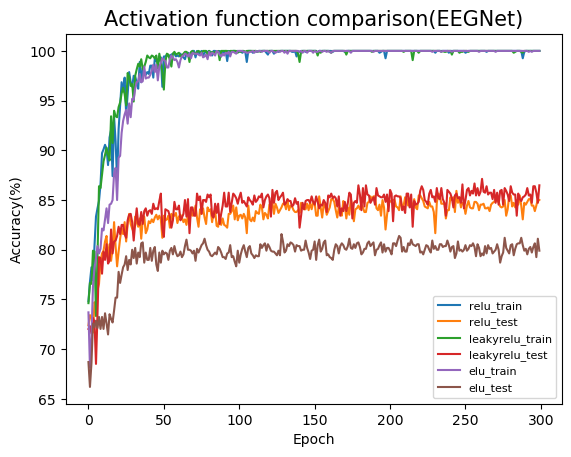

In [16]:
plot_result(EEG_accuracies, networks[0])

## Plot DeepConvNet

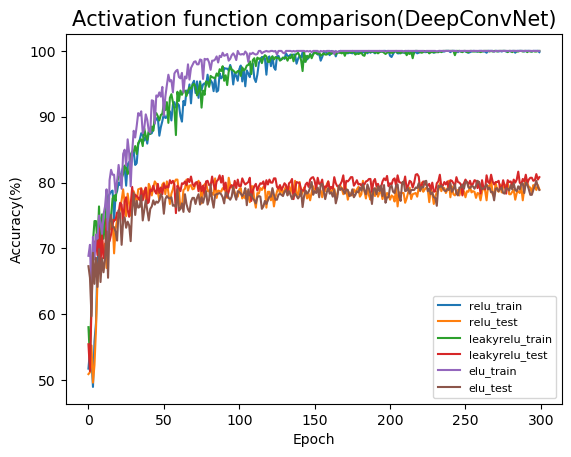

In [17]:
plot_result(Deep_accuracies, networks[1])

In [18]:
print(highest_test_accuracies)

[85.926, 87.13, 81.574, 80.741, 81.667, 80.278]
